# **Intro linear latent space arithmetic PCA**
In this notebook I use a PCA in order to predict the gene expression changes induced by a perturbation.
Here, we want to know the cell-type specific perturbation effect.
We use unperturbed single-cell and pert+unpert bulk in order to infer the cell-type specific expressiom change.
To do this, we use latent space arithmetic, where the latent space is the PCA space. 





# **Imports**

In [1]:
# general imports
import warnings
import numpy as np
import scanpy as sc
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Softmax, ReLU, ELU, LeakyReLU
from tensorflow.keras.layers import concatenate as concat
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mean_absolute_error, mean_squared_error, KLDivergence
from tensorflow.keras.datasets import mnist
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.utils import to_categorical, normalize, plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.stats import spearmanr, pearsonr, rankdata
from scipy.spatial.distance import euclidean
from sklearn.decomposition import PCA

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, average_precision_score
from PIL import Image

from tqdm import tnrange, tqdm_notebook
import ipywidgets

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, MinMaxScaler, StandardScaler
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet

# programming stuff
import time
import os
import pickle
from pathlib import Path

# import the SC_preprocessing code
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from buddi.preprocessing import sc_preprocess
from buddi.plotting import validation_plotting as vp


# disable eager execution
# https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


2024-09-12 18:08:55.323026: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-12 18:08:55.324048: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-12 18:08:55.345273: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-12 18:08:55.346103: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-12 18:08:55.725008: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

In [2]:
from importlib import reload  # Python 3.4+
reload(sc_preprocess)
reload(vp)

<module 'buddi.plotting.validation_plotting' from '/home/natalie/projects/checkouts/buddi/buddi/plotting/validation_plotting.py'>

In [3]:
## parameters
sc_aug_data_path = f"{os.getcwd()}/../../data/single_cell_data/augmented_sciplex_data/"
res_data_path = f"{os.getcwd()}/../../results/single_cell_data/bp_sciplex/"

cibersort_genes_path = (f"{os.getcwd()}/../../data/single_cell_data/cibersort_sciplex/" +
                        "CIBERSORTx_Job67_test_cybersort_sig_inferred_phenoclasses" +
                        ".CIBERSORTx_Job67_test_cybersort_sig_inferred_refsample.bm.K999.txt")

cibersort_path = f"{os.getcwd()}/../../data/single_cell_data/cibersort_sciplex/"

# bp results
bp_res_path = f"{os.getcwd()}/../../results/single_cell_data/bp_sciplex/"

num_genes = 7000

exp_id = "all-sciplex"
curr_treatment = "A549"
res_id = f"{curr_treatment}-sciplex"




# Set-up experimental variables

In [4]:

##################################################
#####. set up experiment specific variables
##################################################

# number expected cell types
n_cell_types = 3

# number of patients/domains/samples expected
n_tot_samples = 1 # 

# number of drugs 
# one-hot encoded
n_drugs = 6

# number of types of sequencing (one-hot encoded)
n_tech = 2


# **Load / Pre-process data**
Import pre-processed pseudobulks

In [5]:


# read in all the data

stim_order = ['CTRL', "STIM"]
train_order = ['Train', "Test"]
cell_order = [curr_treatment]
drug_order = ["Tanespimycin (17-AAG)", "Fedratinib (SAR302503, TG101348)",
              "Trametinib (GSK1120212)", "Triamcinolone Acetonide", "Trichostatin A (TSA)"]

X_full = None
Y_full = None
meta_df = None
for curr_train in train_order:
    for curr_stim in stim_order:
        for curr_drug in drug_order:
            for curr_cell_type in cell_order:

                curr_samp = f"{curr_drug}_{curr_cell_type}"

                print(curr_samp)

                pseudobulks_df, prop_df, gene_df, sig_df, metadata_df = sc_preprocess.read_single_pseudobulk_file(sc_aug_data_path, curr_samp, curr_stim, curr_train, exp_id)
                pseudobulks_df.columns = gene_df

                if X_full is None:
                    X_full, Y_full, meta_df = pseudobulks_df, prop_df, metadata_df
                else:
                    X_full = pd.concat([X_full, pseudobulks_df])
                    Y_full = pd.concat([Y_full, prop_df])
                    meta_df = pd.concat([meta_df, metadata_df])

X_full.columns = gene_df

# the perturbation is applied in a cell type specific manner
meta_df['perturbation'] = meta_df['perturbation'] + '_' + meta_df['cell_type_perturbed']
meta_df['perturbation'].iloc[np.where(meta_df.stim == "CTRL")] = "control"
meta_df["sample_id"] = "samp1"

# for the bulks, only keep the samples with
# the perturbed cell type as the majority
# or less than 20%

Y_max = np.copy(Y_full)
Y_max = np.argmax(Y_max, axis=1)
Y_max = Y_full.columns[Y_max]
meta_df["Y_max"] = Y_max

#idx_sc = np.where(meta_df.samp_type != "bulk")[0]
#idx_bulk_pert = np.where((meta_df.samp_type == "bulk") & (meta_df.Y_max == curr_treatment))[0]
#idx_keep = np.union1d(idx_sc, idx_bulk_pert)

#X_full = X_full.iloc[idx_keep]
#Y_full = Y_full.iloc[idx_keep]
#meta_df = meta_df.iloc[idx_keep]

Tanespimycin (17-AAG)_K562
Fedratinib (SAR302503, TG101348)_K562
Trametinib (GSK1120212)_K562
Triamcinolone Acetonide_K562
Trichostatin A (TSA)_K562
Tanespimycin (17-AAG)_K562
Fedratinib (SAR302503, TG101348)_K562
Trametinib (GSK1120212)_K562
Triamcinolone Acetonide_K562
Trichostatin A (TSA)_K562
Tanespimycin (17-AAG)_K562
Fedratinib (SAR302503, TG101348)_K562
Trametinib (GSK1120212)_K562
Triamcinolone Acetonide_K562
Trichostatin A (TSA)_K562
Tanespimycin (17-AAG)_K562
Fedratinib (SAR302503, TG101348)_K562
Trametinib (GSK1120212)_K562
Triamcinolone Acetonide_K562
Trichostatin A (TSA)_K562


In [6]:

##################################################
#####. Design the experiment
##################################################


X_orig = np.copy(X_full)

# set up the metadata arrays and indices
samp_label = np.asarray(meta_df.sample_id)
index_label, numeric_label = np.unique(samp_label, return_inverse=True)
Label_full = numeric_label
label_full = to_categorical(numeric_label)

samp_drug = np.asarray(meta_df.perturbation)
index_drug, numeric_drug = np.unique(samp_drug, return_inverse=True)
Drug_full = numeric_drug
drug_full = to_categorical(numeric_drug)

samp_bulk = np.asarray(meta_df.samp_type)
index_bulk, numeric_bulk = np.unique(samp_bulk, return_inverse=True)
Bulk_full = numeric_bulk
bulk_full = to_categorical(numeric_bulk)


idx_train = np.where(meta_df.isTraining=="Train")[0] 
idx_test = np.where(meta_df.isTraining!="Train")[0] 
idx_bulk = np.where(meta_df.samp_type == "bulk")[0]
idx_sc = np.where(meta_df.samp_type != "bulk")[0]
idx_drug = np.where(meta_df.stim != "CTRL")[0]
idx_random = np.where(meta_df.cell_prop_type == "random")[0]

Y_max = np.copy(Y_full)
Y_max = np.argmax(Y_max, axis=1)
Y_max = Y_full.columns[Y_max]
meta_df["Y_max"] = Y_max

# now seperate out the training and testing data
X_train_df = X_full.iloc[idx_train]
Y_train_df = Y_full.iloc[idx_train]


# try using the cibersort genes
cibersort_df = pd.read_csv(cibersort_genes_path, sep="\t" )
cibersort_genes = cibersort_df["NAME"].values.tolist()

# only keep cibersort genes that are in common genes
cibersort_genes = np.intersect1d(gene_df, cibersort_genes)

# convert to data matrices
X_train = X_train_df.to_numpy()
Y_train = Y_train_df.to_numpy()


## get the top variable genes
X_colmean = X_train.mean(axis=0)
X_colvar = X_train.var(axis=0)
X_CoV = np.array(np.divide(X_colvar, X_colmean+0.001))

# need to get the genes such that
# the union of the highly variable and the
# CIBERSORTx genes are 7000 total
num_genes_found = False
initial_count = 7000
while not num_genes_found:
    idx_top = np.argpartition(X_CoV, -initial_count)[-initial_count:]
    top_gene_df = gene_df.iloc[idx_top]
    CoV_only = np.union1d(top_gene_df, cibersort_genes)
    if len(CoV_only) == 7000:
        num_genes_found = True
    else:
        initial_count = initial_count -1

idx_top = np.argpartition(X_CoV, -initial_count)[-initial_count:] 
gene_df = gene_df.iloc[idx_top]



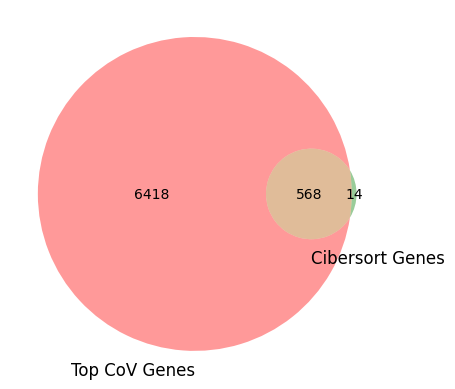

In [7]:

venn2([set(gene_df), set(cibersort_genes)], set_labels = ('Top CoV Genes', 'Cibersort Genes'))
plt.show()

In [8]:
union_genes = np.union1d(gene_df, cibersort_genes)


# Read in BP data

In [9]:

def read_bp_result_file(res_path, curr_treatment):
    res_file = os.path.join(res_path, f"{curr_treatment}_bp_expr.tsv")
    res_df = pd.read_csv(res_file, sep="\t")
    return res_df


In [10]:

# read in BP
bp_df  = read_bp_result_file(bp_res_path, curr_treatment)
bp_genes = np.intersect1d(union_genes, bp_df.columns)

sig_out_file = os.path.join(cibersort_path, f"{curr_treatment}_cybersort_meta.tsv.gz")
sig_out_path = Path(sig_out_file)
meta_df_cibersort =  pd.read_csv(sig_out_path, sep='\t')
meta_df_cibersort["sample_id"] = [f"samp{x}" for x in range(0,meta_df_cibersort.shape[0])]

# get meta data
meta_bp_df = bp_df[["cell_type", "samp_ID"]]
meta_bp_df["sample_id"] = [f"samp{x}" for x in bp_df.samp_ID]

ref_meta_df = meta_df_cibersort.copy()

# right join to maintain order 
meta_bp_df = ref_meta_df.merge(meta_bp_df, how='right', on='sample_id')

# Y_max no longer matters for this BP sample, this is referencing the cell_type
meta_bp_df["Y_max"] = meta_bp_df["cell_type"]

# this is also all going to be used in our testing
meta_bp_df["isTraining"] = "Test"


# get the overlapping genes
bp_union_genes = np.intersect1d(bp_df.columns, union_genes) 

# subset to union genes
bp_df = bp_df.loc[:,bp_union_genes]


# subset original data to the BP genes as well
X_full = pd.DataFrame(X_full, columns=union_genes)

X_full = X_full.loc[:,bp_union_genes]
X_full = X_full.to_numpy()


/tmp/ipykernel_1194819/3821688454.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_bp_df["sample_id"] = [f"samp{x}" for x in bp_df.samp_ID]


# Normalize input data

In [11]:


## normalize within sample
clip_upper = np.quantile(X_full, 0.9)
X_full = np.clip(X_full, 0, clip_upper)
scaler = MinMaxScaler()
scaler.fit(X_full)

# now normalize with the scaler trained on the 
# training data
X_full = np.clip(X_full, 0, clip_upper)
X_full = scaler.transform(X_full)


# for unknown proportions; 
# this is bulks used in training
idx_bulk_train = np.intersect1d(idx_bulk, idx_train) 
X_unkp = X_full[idx_bulk_train,]
label_unkp = label_full[idx_bulk_train,]
drug_unkp = drug_full[idx_bulk_train,]
y_unkp = Y_full.iloc[idx_bulk_train]
y_unkp = y_unkp.to_numpy()

# for known proportions
idx_sc_train = np.intersect1d(idx_sc, idx_train) 
X_kp = X_full[idx_sc_train,]
label_kp = label_full[idx_sc_train,]
drug_kp = drug_full[idx_sc_train,]
y_kp = Y_full.iloc[idx_sc_train]
y_kp = y_kp.to_numpy()





# **Inspect BP output**

In [12]:
bp_df

,AAAS,AACS,AAED1,AAGAB,AAK1,AAMDC,AAMP,AARS,AASDH,AATF,...,ZSWIM7,ZSWIM8,ZUFSP,ZWILCH,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,17.176,31.340,19.368,89.392,165.148,16.128,17.868,98.680,20.292,142.680,...,56.128,21.188,8.824,43.024,50.068,22.476,64.140,21.980,100.652,103.280
1,18.776,35.748,17.488,88.984,181.420,15.484,14.172,104.892,17.444,137.716,...,50.604,22.080,8.464,44.564,52.216,24.620,62.532,19.368,99.992,97.080
2,16.408,27.476,15.316,73.304,150.752,12.332,10.512,89.336,14.424,108.392,...,41.976,17.868,6.624,39.352,42.732,21.820,51.392,15.812,82.484,84.684
3,166.268,419.940,196.180,1032.000,2045.032,201.536,154.692,1002.012,192.072,1425.508,...,588.736,227.100,100.008,501.800,566.796,309.028,712.160,220.576,1114.228,1181.452
4,1.020,2.044,1.616,5.304,10.020,1.076,0.948,6.196,1.016,8.620,...,3.500,1.392,0.600,2.668,2.876,1.516,3.772,1.404,6.332,6.252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,376.992,886.060,184.844,1405.052,1885.484,371.568,273.828,1737.208,297.572,908.584,...,543.336,560.328,262.808,681.116,1690.748,516.016,1057.156,420.412,1680.876,2582.720
290,40.020,91.648,19.712,149.396,205.868,58.320,39.248,184.800,35.164,89.960,...,62.644,63.348,28.764,76.952,193.484,62.124,134.028,41.476,193.916,267.256
291,34.508,19.112,19.388,63.060,108.396,30.296,16.128,90.132,14.100,31.256,...,41.344,19.160,14.704,23.644,65.596,27.188,68.108,9.440,96.808,72.732
292,453.032,923.996,210.184,1611.324,2035.948,426.380,344.836,1819.024,293.768,954.588,...,560.480,571.316,256.632,681.396,1789.400,606.680,1221.948,482.988,1899.104,2718.300


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 294 samples in 0.004s...
[t-SNE] Computed neighbors for 294 samples in 0.034s...
[t-SNE] Computed conditional probabilities for sample 294 / 294
[t-SNE] Mean sigma: 830.681457
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.747856
[t-SNE] KL divergence after 500 iterations: 0.125283
(294, 2)
(294, 2)


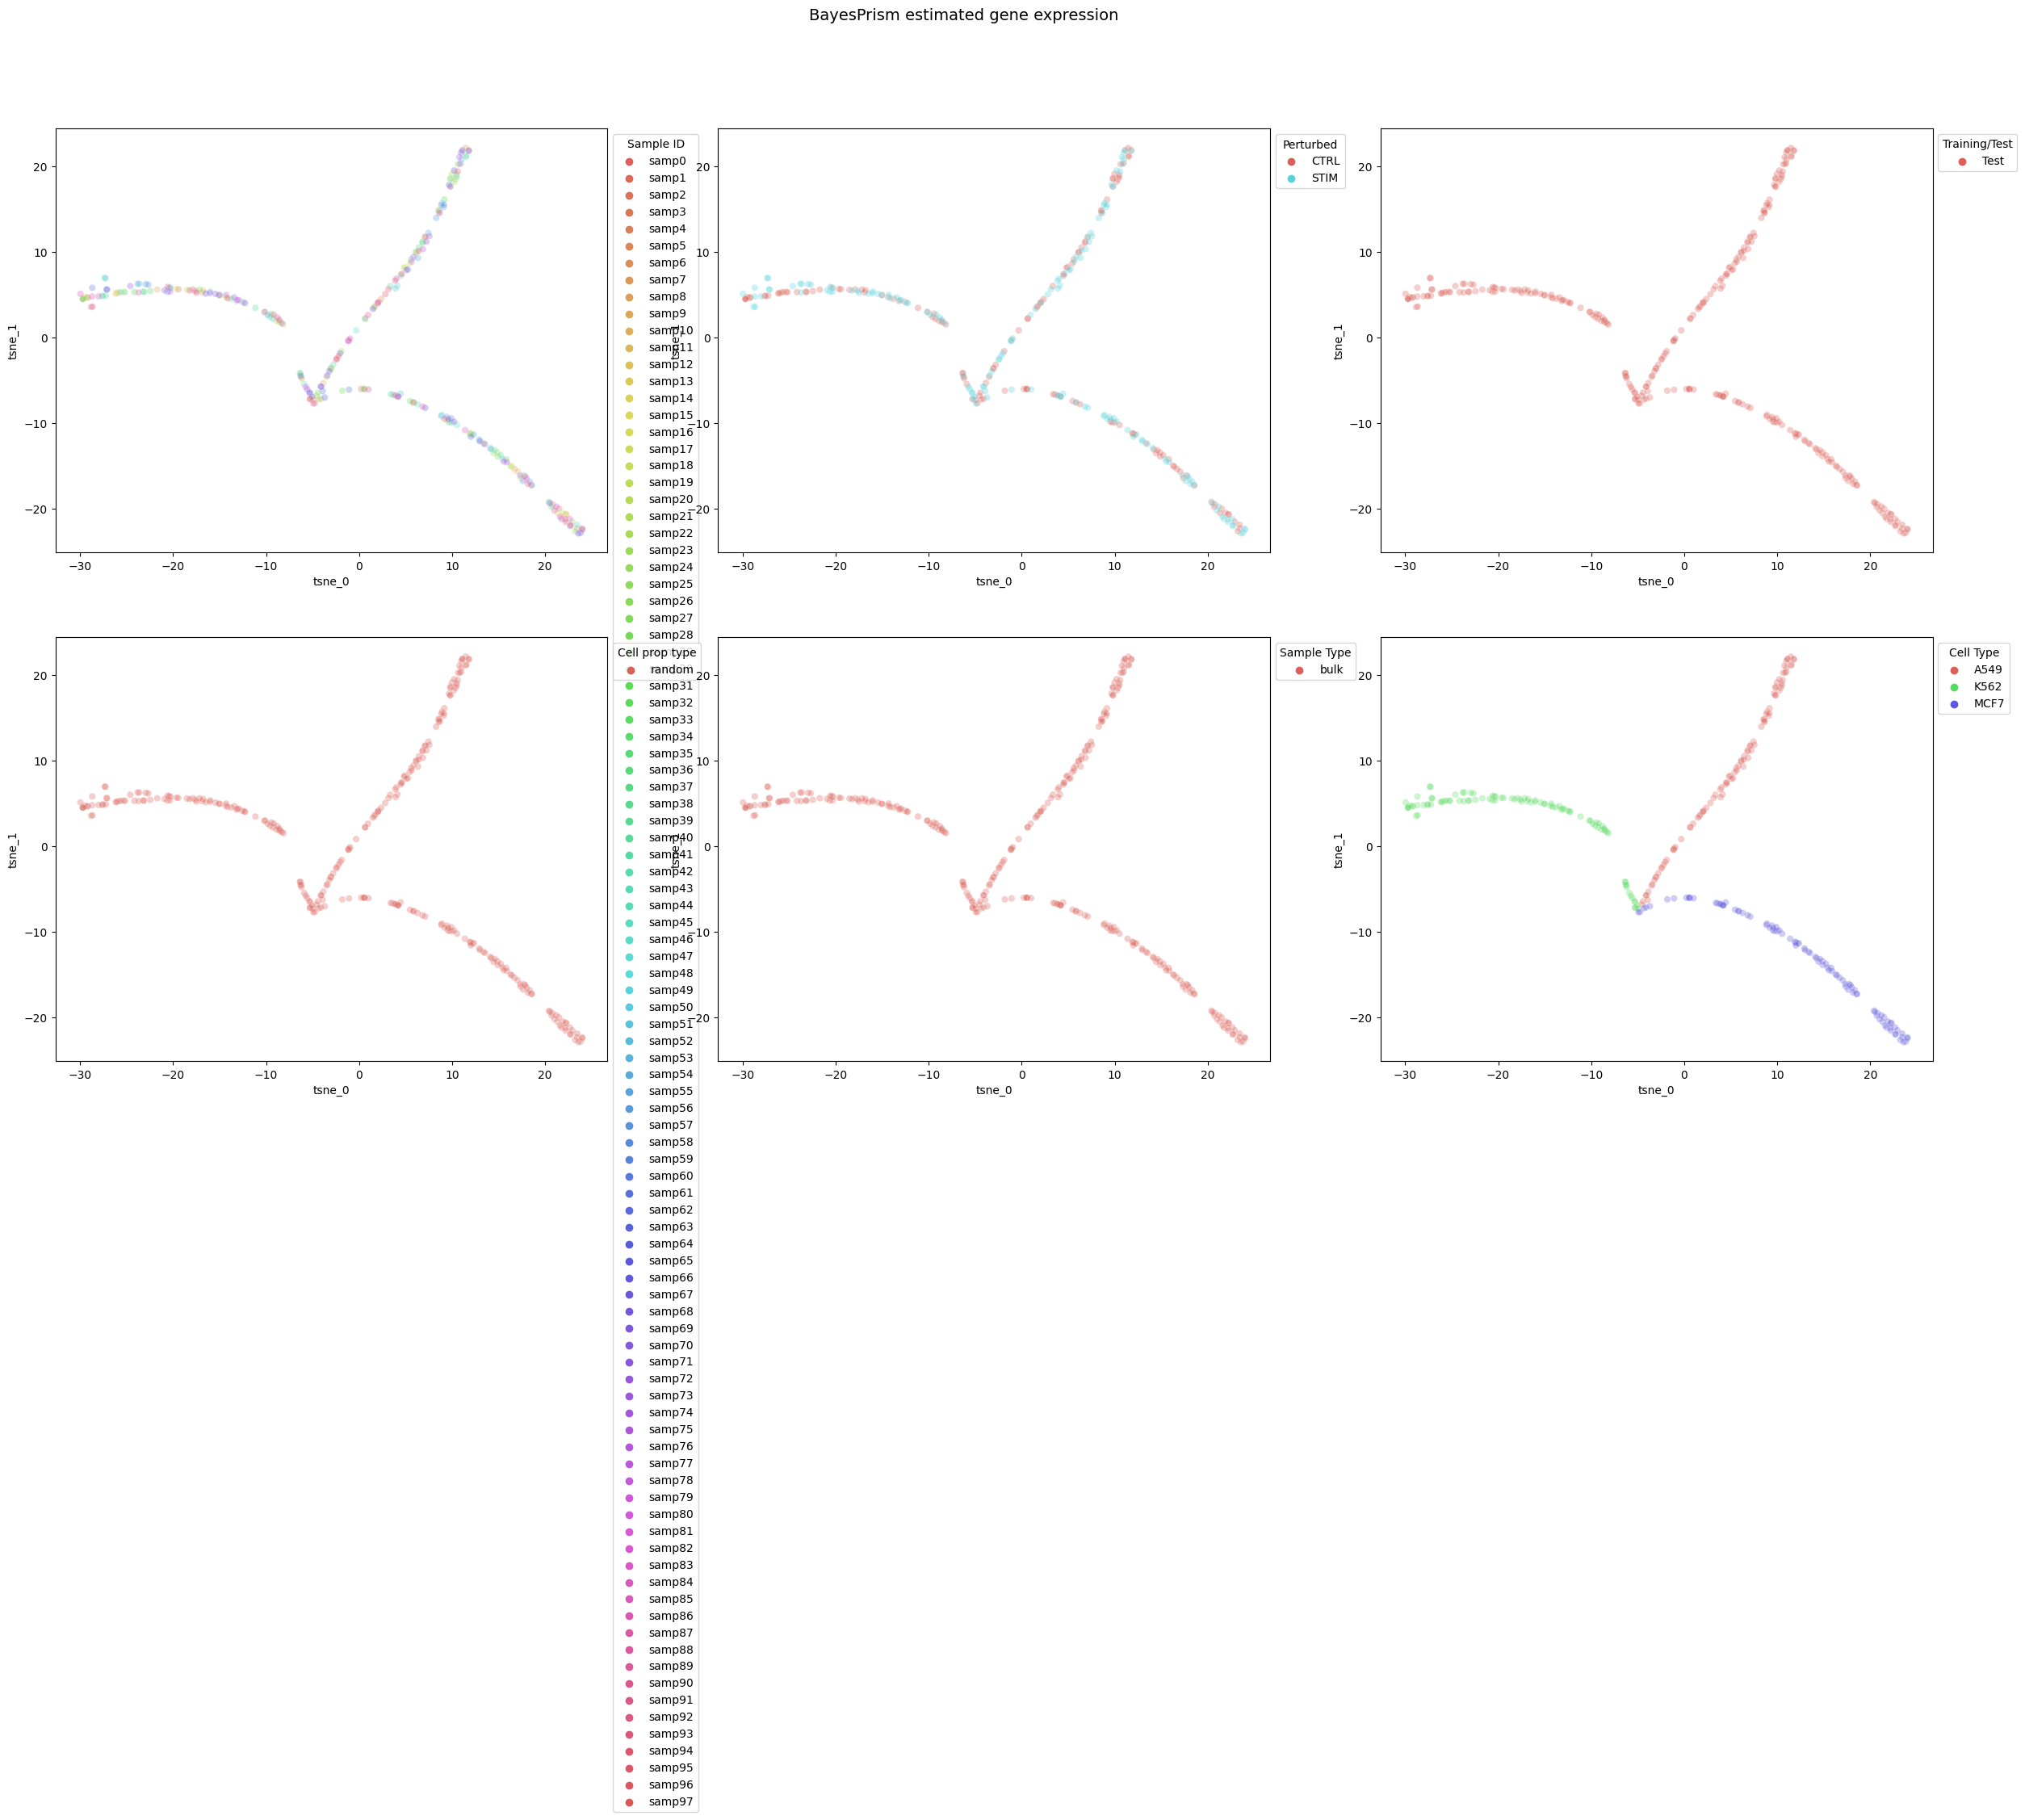

In [13]:
## plot samples
plot_df = vp.get_tsne_for_plotting(bp_df)

fig, axs = plt.subplots(2, 3, figsize=(30,15))


vp.plot_tsne(plot_df, meta_bp_df.sample_id.to_numpy(), axs[0,0], legend_title="Sample ID", title=f"", alpha=1)
vp.plot_tsne(plot_df, meta_bp_df.stim.to_numpy(), axs[0,1], legend_title="Perturbed", title=f"", alpha=1)
vp.plot_tsne(plot_df, meta_bp_df.isTraining.to_numpy(), axs[0,2], legend_title="Training/Test", title=f"", alpha=1)
vp.plot_tsne(plot_df, meta_bp_df.cell_prop_type.to_numpy(), axs[1,0], legend_title="Cell prop type", title=f"", alpha=1)
vp.plot_tsne(plot_df, meta_bp_df.samp_type.to_numpy(), axs[1,1], legend_title="Sample Type", title=f"", alpha=1)
vp.plot_tsne(plot_df, meta_bp_df.cell_type.to_numpy(), axs[1,2], legend_title="Cell Type", title=f"", alpha=1)


fig.suptitle("BayesPrism estimated gene expression", fontsize=14)


fig.show()


In [14]:
meta_bp_df

,Unnamed: 0,sample_id,stim,isTraining,cell_prop_type,samp_type,perturbation,cell_type_perturbed,Y_max,cell_type,samp_ID
0,9,samp0,CTRL,Test,random,bulk,control,K562,A549,A549,0
1,47,samp1,CTRL,Test,random,bulk,control,K562,A549,A549,1
2,117,samp2,CTRL,Test,random,bulk,control,K562,A549,A549,2
3,172,samp3,CTRL,Test,random,bulk,control,K562,A549,A549,3
4,192,samp4,CTRL,Test,random,bulk,control,K562,A549,A549,4
...,...,...,...,...,...,...,...,...,...,...,...
289,384,samp93,STIM,Test,random,bulk,Trichostatin A (TSA)_K562,K562,MCF7,MCF7,93
290,396,samp94,STIM,Test,random,bulk,Trichostatin A (TSA)_K562,K562,MCF7,MCF7,94
291,398,samp95,STIM,Test,random,bulk,Trichostatin A (TSA)_K562,K562,MCF7,MCF7,95
292,426,samp96,STIM,Test,random,bulk,Trichostatin A (TSA)_K562,K562,MCF7,MCF7,96


(294, 2)
(294, 2)


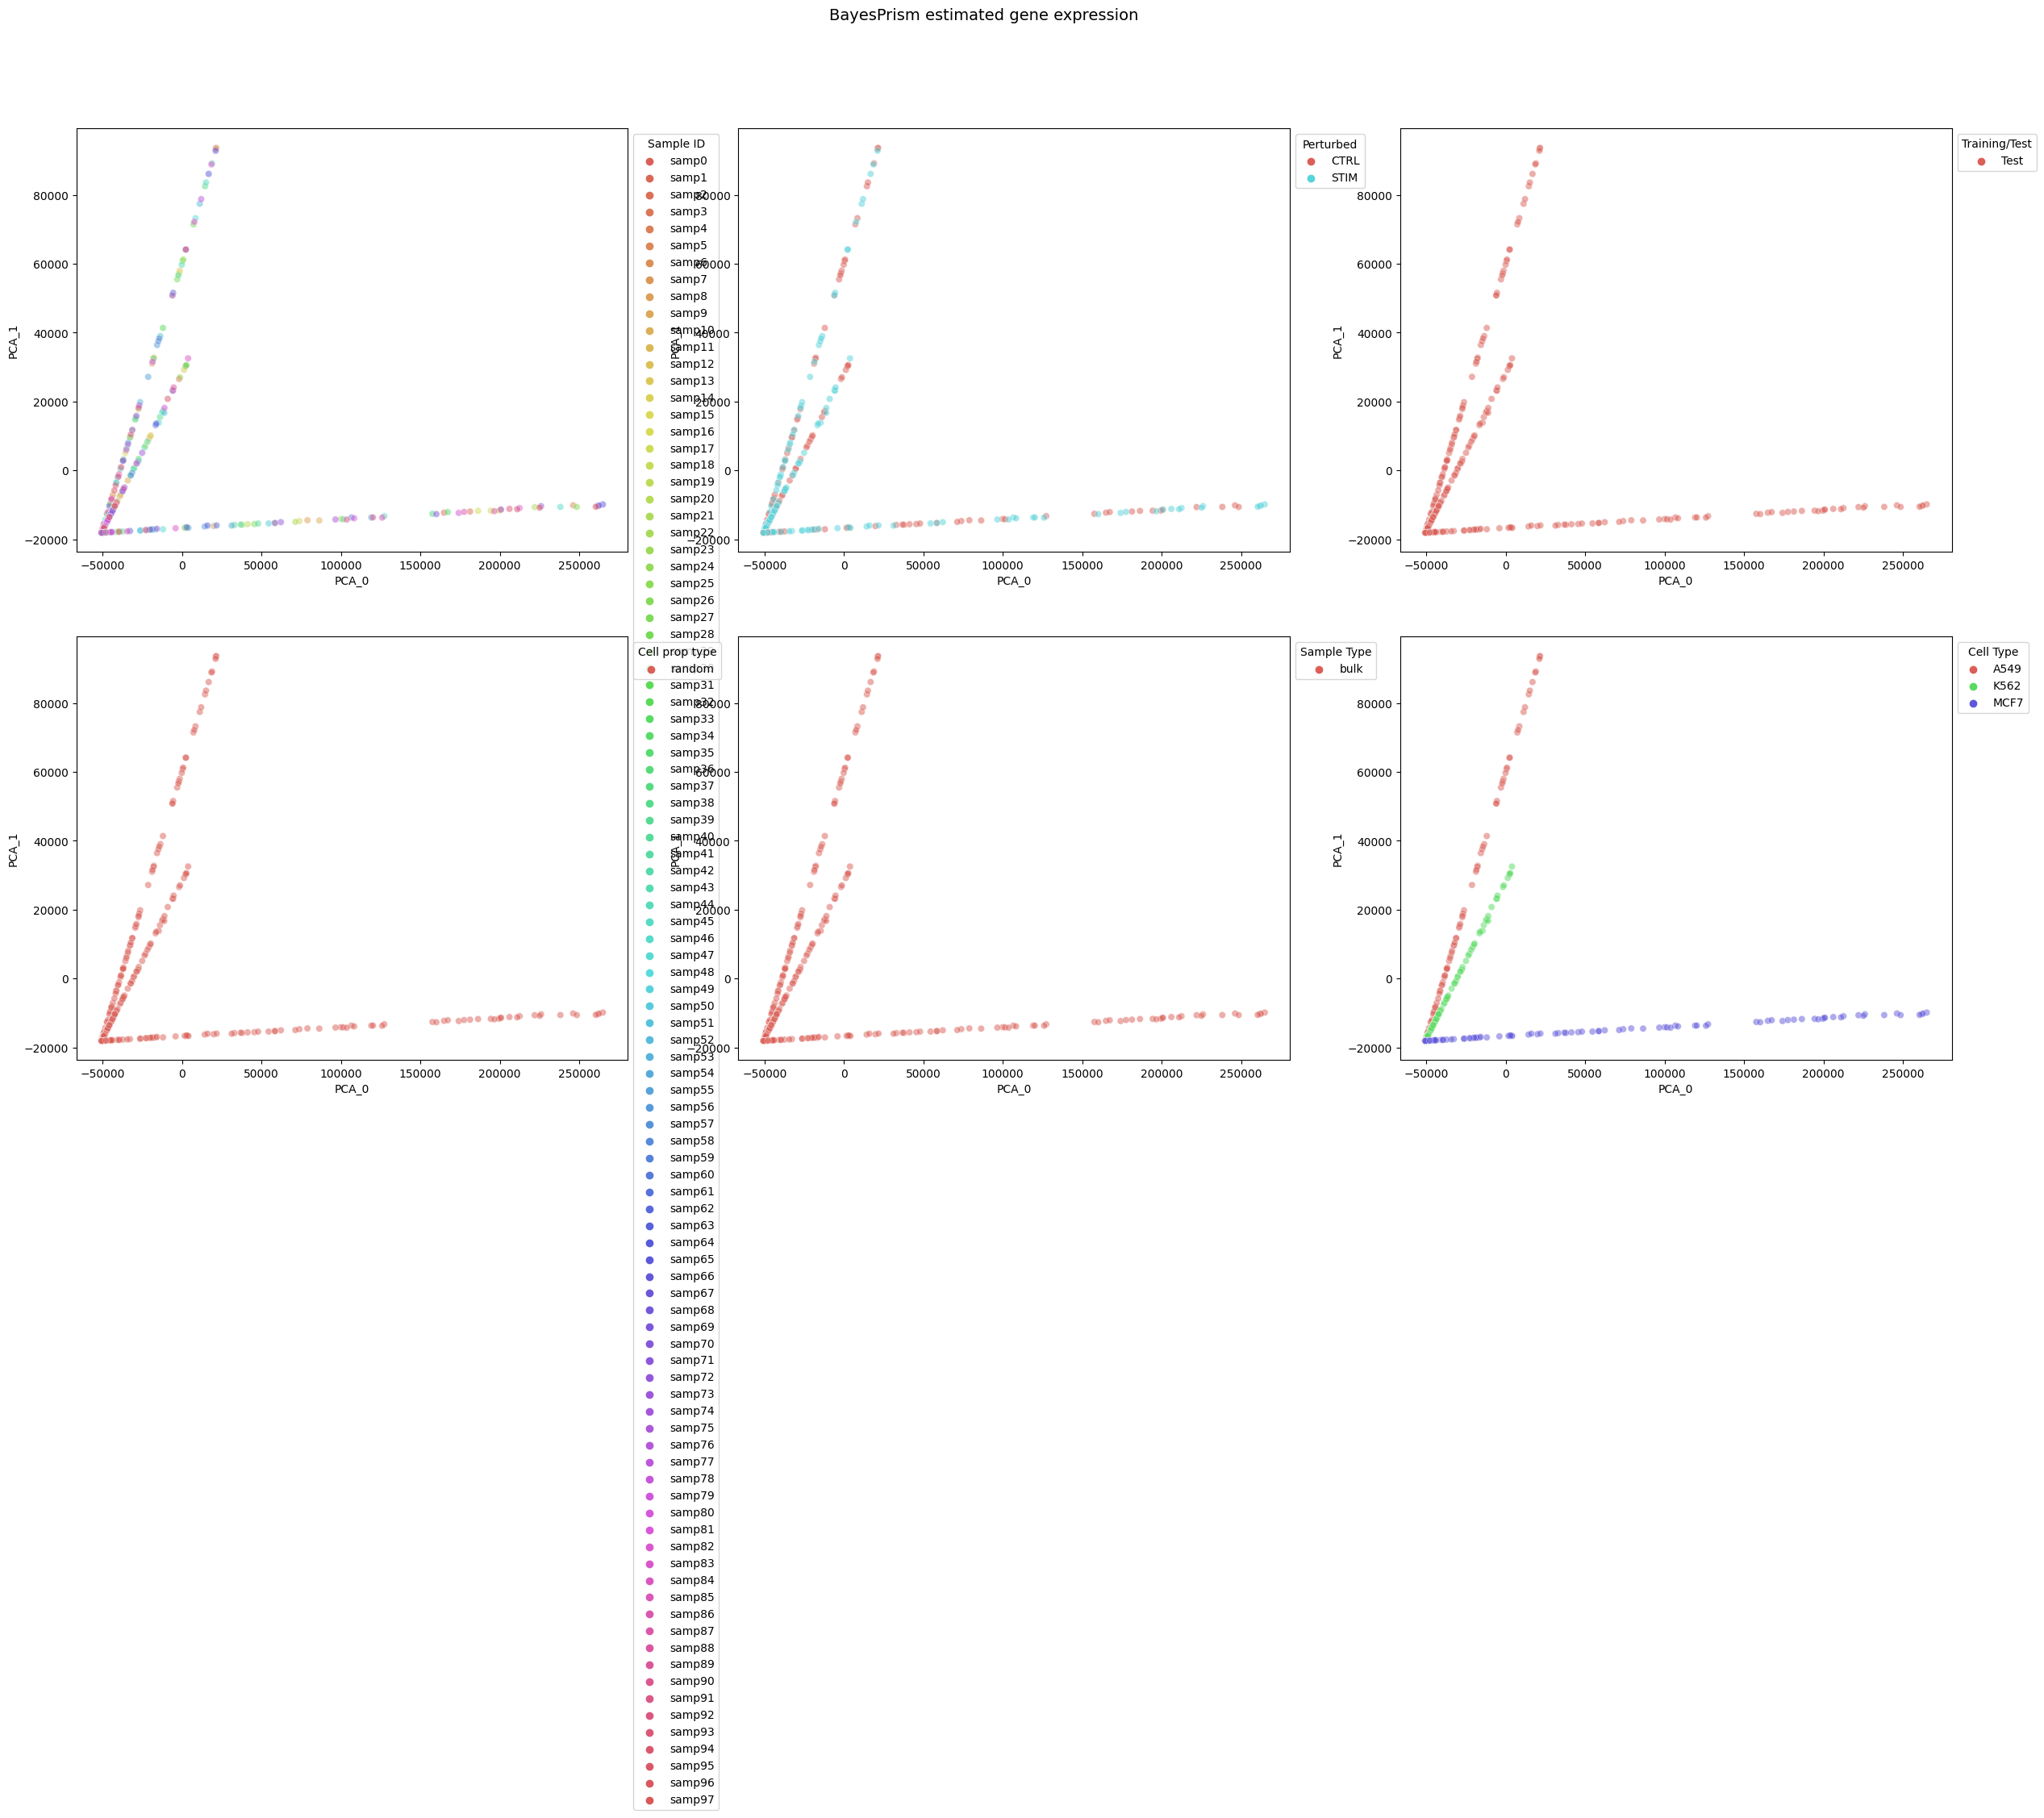

In [15]:
## plot samples
plot_df = vp.get_pca_for_plotting(bp_df)

fig, axs = plt.subplots(2, 3, figsize=(30,15))


vp.plot_pca(plot_df, meta_bp_df.sample_id.to_numpy(), axs[0,0], legend_title="Sample ID", title=f"", alpha=0.5)
vp.plot_pca(plot_df, meta_bp_df.stim.to_numpy(), axs[0,1], legend_title="Perturbed", title=f"", alpha=0.5)
vp.plot_pca(plot_df, meta_bp_df.isTraining.to_numpy(), axs[0,2], legend_title="Training/Test", title=f"", alpha=0.5)
vp.plot_pca(plot_df, meta_bp_df.cell_prop_type.to_numpy(), axs[1,0], legend_title="Cell prop type", title=f"", alpha=0.5)
vp.plot_pca(plot_df, meta_bp_df.samp_type.to_numpy(), axs[1,1], legend_title="Sample Type", title=f"", alpha=0.5)
vp.plot_pca(plot_df, meta_bp_df.cell_type.to_numpy(), axs[1,2], legend_title="Cell Type", title=f"", alpha=0.5)


fig.suptitle("BayesPrism estimated gene expression", fontsize=14)


fig.show()


## Do latent space projections

### drug perturbation

In [16]:

def subset_sample_celltype_perturbation(X_full, meta_df, bp_decoded, 
                                        ctrl_test_meta_df, cell_prop_type,
                                        scaler, cell_type_interest=None):


    # get the real data
    X_tmp = np.copy(X_full)
    X_tmp = scaler.inverse_transform(X_tmp)

    # get the ground truth
    real_stimulated_idx = np.logical_and(meta_df.stim == "STIM", meta_df.isTraining == "Test")
    real_stimulated_idx = np.logical_and(real_stimulated_idx, meta_df.cell_prop_type == cell_prop_type)

    if cell_type_interest is not None:
        real_stimulated_idx = np.logical_and(real_stimulated_idx, meta_df.Y_max == cell_type_interest)
    real_stimulated_idx = np.where(real_stimulated_idx)[0]
    real_original_stim = X_tmp[real_stimulated_idx]


    real_ctrl_idx = np.logical_and(meta_df.stim == "CTRL", meta_df.isTraining == "Test")
    real_ctrl_idx = np.logical_and(real_ctrl_idx, meta_df.cell_prop_type == cell_prop_type)
    if cell_type_interest is not None:
        real_ctrl_idx = np.logical_and(real_ctrl_idx, meta_df.Y_max == cell_type_interest)
    real_ctrl_idx = np.where(real_ctrl_idx)[0]
    real_original_ctrl = X_tmp[real_ctrl_idx]



    # get the reconstructed 
    recon_Zstim_idx = np.logical_and(ctrl_test_meta_df.stim == "CTRL", ctrl_test_meta_df.isTraining == "Test")
    if cell_type_interest is not None:
        recon_Zstim_idx = np.logical_and(recon_Zstim_idx, ctrl_test_meta_df.Y_max == cell_type_interest)
    recon_Zstim_idx = np.where(recon_Zstim_idx)[0]
    projected_ctrl = bp_decoded.iloc[recon_Zstim_idx]

    recon_Zstim_idx = np.logical_and(ctrl_test_meta_df.stim == "STIM", ctrl_test_meta_df.isTraining == "Test")
    if cell_type_interest is not None:
        recon_Zstim_idx = np.logical_and(recon_Zstim_idx, ctrl_test_meta_df.Y_max == cell_type_interest)
    recon_Zstim_idx = np.where(recon_Zstim_idx)[0]
    projected_Zstimulated = bp_decoded.iloc[recon_Zstim_idx]


    return (real_original_stim, real_original_ctrl, projected_Zstimulated, projected_ctrl)


In [17]:
from scipy.stats import ttest_ind
import math


def get_nonperturbed_log2fc(curr_cell_type_perturbed,
                            meta_df, X_full, bp_df, 
                            meta_bp_df, scaler):
    

    ct_perturbed_idx = np.where(meta_df["cell_type_perturbed"] == curr_cell_type_perturbed)[0]
    ct_perturbed_idx_bp = np.where(meta_bp_df["cell_type_perturbed"] == curr_cell_type_perturbed)[0]

    all_perts = meta_df.iloc[ct_perturbed_idx].perturbation.unique()
    all_perts = np.setdiff1d(all_perts, "control")

    all_Ymax = np.setdiff1d(meta_df.Y_max.unique(), curr_cell_type_perturbed)

    curr_cell_type = curr_cell_type_perturbed

    res_df = None
    log2fc_df = None
    for curr_drug in all_perts:
        for curr_Ymax in all_Ymax:

            print(f"{curr_drug} {curr_Ymax} {curr_cell_type_perturbed}")

            drug_idx = np.where((meta_df["perturbation"] == curr_drug) | (meta_df["perturbation"] == "control"))[0]
            drug_idx_bp = np.where((meta_bp_df["perturbation"] == curr_drug) | (meta_bp_df["perturbation"] == "control"))[0]

            curr_idx = np.intersect1d(drug_idx, ct_perturbed_idx)
            curr_idx_bp = np.intersect1d(drug_idx_bp, ct_perturbed_idx_bp)
            real_stim, real_ctrl, proj_stim, proj_ctrl = subset_sample_celltype_perturbation(X_full[curr_idx], meta_df.iloc[curr_idx], 
                                                                                             bp_df.iloc[curr_idx_bp], meta_bp_df.iloc[curr_idx_bp],
                                                                                            "cell_type_specific",
                                                                                            scaler, cell_type_interest=curr_Ymax)

            real_p_val = []
            subsamp_idx = np.random.choice(real_stim.shape[0], 9)
            for col_idx in range(real_stim.shape[1]):
                _, p_value = ttest_ind(real_stim[subsamp_idx,col_idx], real_ctrl[subsamp_idx,col_idx])
                real_p_val.append(p_value)

            real_p_val = [1 if math.isnan(x) else x for x in real_p_val]

            proj_p_val = []
            subsamp_idx = np.random.choice(proj_stim.shape[0], 9)
            for col_idx in range(proj_stim.shape[1]):
                _, p_value = ttest_ind(proj_stim.iloc[subsamp_idx,col_idx], proj_ctrl.iloc[subsamp_idx,col_idx])
                proj_p_val.append(p_value)

            proj_p_val = [1 if math.isnan(x) else x for x in proj_p_val]


            real_stim_med = np.median(real_stim, axis=0)
            proj_stim_med = np.median(proj_stim, axis=0)

            real_ctrl_med = np.median(real_ctrl, axis=0)
            proj_ctrl_med = np.median(proj_ctrl, axis=0)


            real_ctrl_med_1 = np.median(real_ctrl, axis=0)+1
            real_stim_med_1 = np.median(real_stim, axis=0)+1
            real_log2FC = np.log2(real_stim_med_1/real_ctrl_med_1)

            proj_ctrl_med_1 = np.median(proj_ctrl, axis=0)+1
            proj_stim_med_1 = np.median(proj_stim, axis=0)+1
            proj_log2FC = np.log2(proj_stim_med_1/proj_ctrl_med_1)

            print(len(proj_log2FC.tolist() +  real_log2FC.tolist()))
            print(len(curr_idx))

            num_sig_real = [True if x < 0.05/len(real_p_val) else False for x in real_p_val]
            num_sig_proj = [True if x < 0.05/len(proj_p_val) else False for x in proj_p_val]

            plot_df = pd.DataFrame({"log2FC": [np.sum(num_sig_proj), np.sum(num_sig_real)],
                                    "source":["proj", "real"],
                                    "Y_max":[curr_Ymax, curr_Ymax],
                                    "perturbation":[curr_drug, curr_drug]})

            curr_log2fc_df = pd.DataFrame({"proj_log2FC":proj_log2FC,
                                           "real_log2FC":real_log2FC,
                                            "Y_max":[curr_Ymax]*len(proj_log2FC),
                                            "perturbation":[curr_drug]*len(proj_log2FC)})
            
            if res_df is None:
                res_df = plot_df
                log2fc_df = curr_log2fc_df
            else:
                res_df = pd.concat([res_df, plot_df])
                log2fc_df = pd.concat([log2fc_df, curr_log2fc_df])

    return res_df, log2fc_df

In [18]:
# per cell type
res1_df, res1_log2fc_df = get_nonperturbed_log2fc(curr_treatment,
                            meta_df, X_full, bp_df, 
                            meta_bp_df, scaler)

Fedratinib (SAR302503, TG101348)_K562 A549 K562


/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


12398
28000
Fedratinib (SAR302503, TG101348)_K562 MCF7 K562


/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


12398
28000
Tanespimycin (17-AAG)_K562 A549 K562


/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


12398
28000
Tanespimycin (17-AAG)_K562 MCF7 K562


/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


12398
28000
Trametinib (GSK1120212)_K562 A549 K562


/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


12398
28000
Trametinib (GSK1120212)_K562 MCF7 K562


/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


12398
28000
Triamcinolone Acetonide_K562 A549 K562


/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


12398
28000
Triamcinolone Acetonide_K562 MCF7 K562


/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


12398
28000
Trichostatin A (TSA)_K562 A549 K562


/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


12398
28000
Trichostatin A (TSA)_K562 MCF7 K562


/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


12398
28000


<AxesSubplot: xlabel='proj_log2FC', ylabel='real_log2FC'>

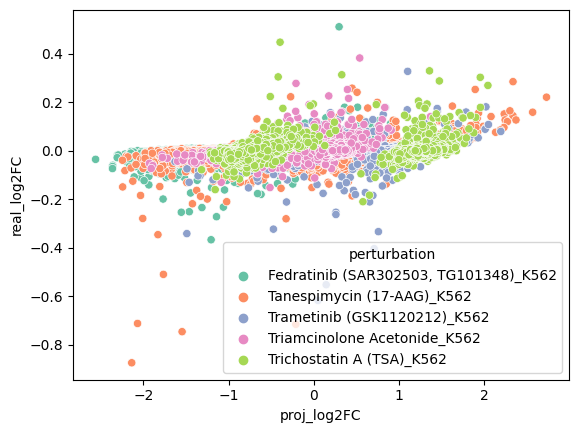

In [19]:
sns.scatterplot(data=res1_log2fc_df, x="proj_log2FC", y="real_log2FC", hue="perturbation")


In [20]:
res1_log2fc_df

,proj_log2FC,real_log2FC,Y_max,perturbation
0,-0.286683,-0.008511,A549,"Fedratinib (SAR302503, TG101348)_K562"
1,-0.506885,-0.007072,A549,"Fedratinib (SAR302503, TG101348)_K562"
2,-0.727627,-0.013939,A549,"Fedratinib (SAR302503, TG101348)_K562"
3,-0.285529,0.000000,A549,"Fedratinib (SAR302503, TG101348)_K562"
4,-0.188274,0.002819,A549,"Fedratinib (SAR302503, TG101348)_K562"
...,...,...,...,...
6194,1.319561,0.013379,MCF7,Trichostatin A (TSA)_K562
6195,1.295152,0.008704,MCF7,Trichostatin A (TSA)_K562
6196,1.225797,-0.006808,MCF7,Trichostatin A (TSA)_K562
6197,1.226910,-0.003037,MCF7,Trichostatin A (TSA)_K562


In [21]:
log2fc_res_file = os.path.join(res_data_path, f"{res_id}_BP_log2fc_null.csv")
res1_df.to_csv(log2fc_res_file, index=False)

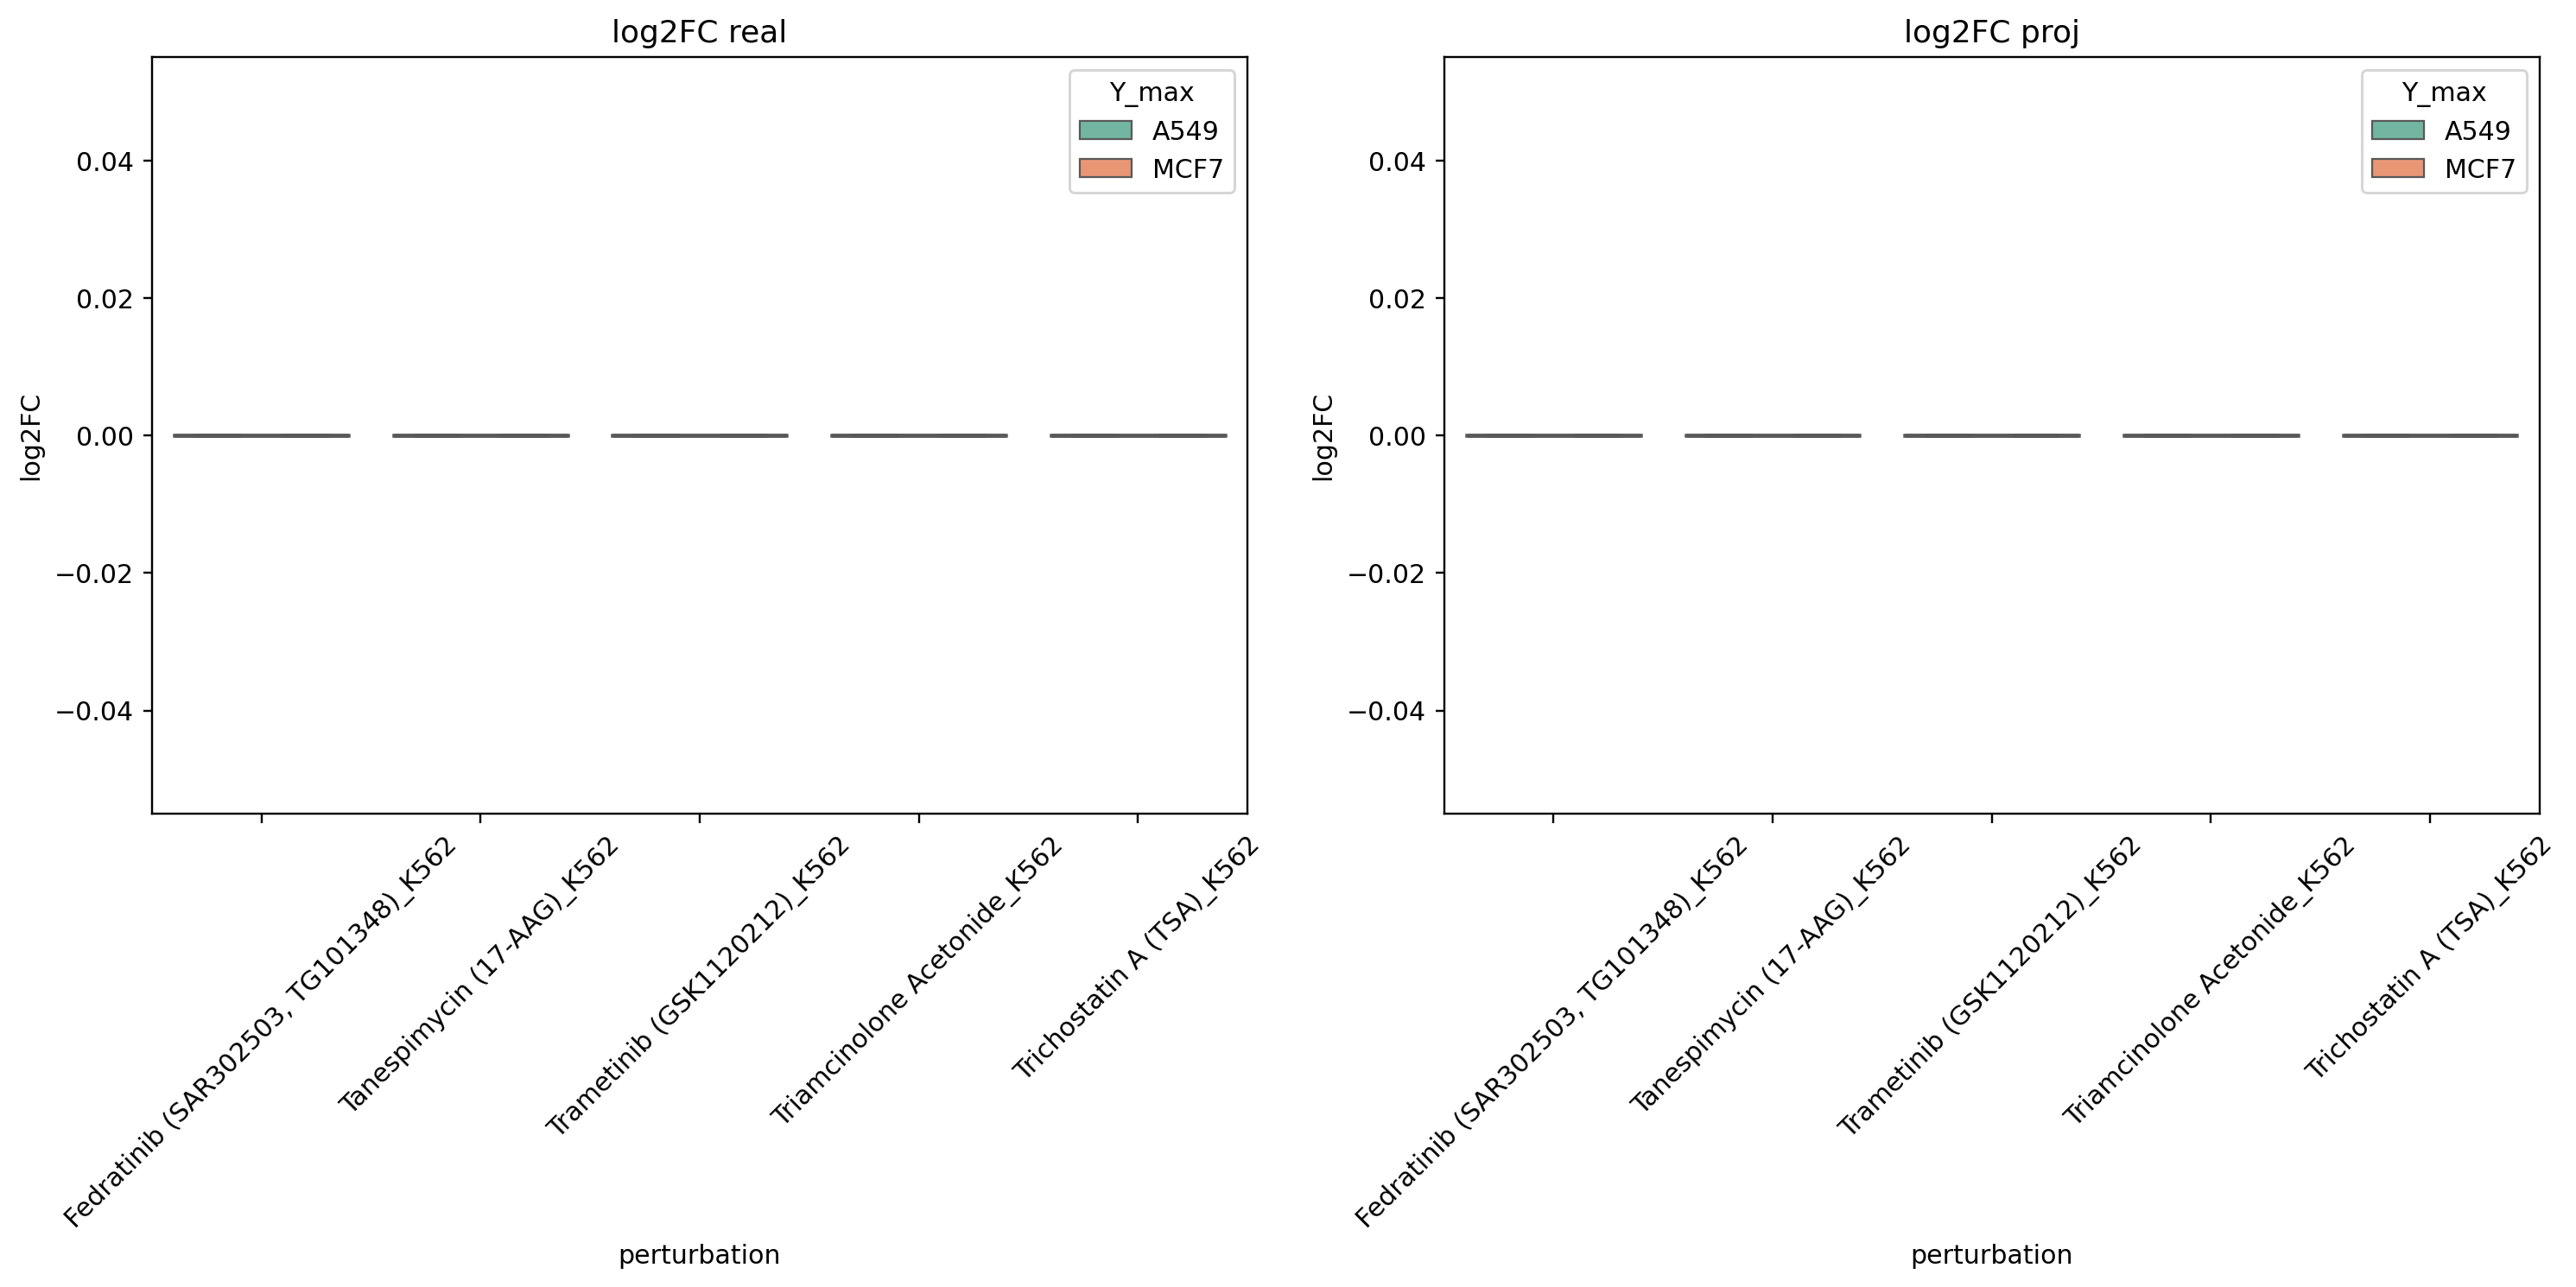

In [22]:

# plot
fig, axs = plt.subplots(1, 2, figsize=(14,7), dpi=216)

sns.boxplot(data=res1_df.iloc[np.where(res1_df.source == "real")[0]], 
            x="perturbation", y="log2FC",
            hue="Y_max", ax= axs[0])
axs[0].set_title("log2FC real")
axs[0].set(ylabel="log2FC")
axs[0].tick_params(axis='x', rotation=45)


sns.boxplot(data=res1_df.iloc[np.where(res1_df.source == "proj")[0]], 
            x="perturbation", y="log2FC",
            hue="Y_max", ax= axs[1])
axs[1].set_title("log2FC proj")
axs[1].set(ylabel="log2FC")
axs[1].tick_params(axis='x', rotation=45)


fig.show()
fig.tight_layout()



# Calculate PRAUC

In [23]:
from matplotlib_venn import venn3
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, roc_curve, precision_recall_curve
from random import sample

sns.set_palette("Set2")

# get PR curve

def plot_PR_ROC(proj_ctrl, proj_stim, real_ctrl, real_stim, curr_cell_type, axs, union_genes, num_top=100):

    # this is for the "projected" expression
    # take the median for nomalization
    proj_ctrl = np.median(rankdata(proj_ctrl, axis=1), axis=0)
    proj_stim = np.median(rankdata(proj_stim, axis=1), axis=0)
    proj_log2FC = abs(proj_stim-proj_ctrl)


    real_stim = np.median(rankdata(real_stim, axis=1), axis=0)
    real_ctrl = np.median(rankdata(real_ctrl, axis=1), axis=0)
    real_log2FC = abs(real_stim-real_ctrl)


    # make dataframe of true/false positives
    proj_log2FC_df = pd.DataFrame({"proj_log2FC":proj_log2FC,
                                    "real_log2FC":real_log2FC}, index=union_genes)
    proj_log2FC_df["orig"] = proj_stim-proj_ctrl

    # make a random one
    temp_samp = sample(proj_log2FC_df["proj_log2FC"].tolist(), len(proj_log2FC_df["proj_log2FC"].tolist()))
    temp_samp = [int(a) for a in temp_samp]
    proj_log2FC_df["random"] = temp_samp


    proj_log2FC_df["top_DE"] = 0
    proj_log2FC_df = proj_log2FC_df.sort_values(["real_log2FC"], ascending=False)
    proj_log2FC_df.top_DE.iloc[range(0,num_top)] = 1




    # now do the single-cell cell type specific DE
    roc_display = RocCurveDisplay.from_predictions(proj_log2FC_df.top_DE, proj_log2FC_df["proj_log2FC"], name="CVAE", ax=axs[0])
    pr_display = PrecisionRecallDisplay.from_predictions(proj_log2FC_df.top_DE, proj_log2FC_df["proj_log2FC"], name="CVAE", ax=axs[1])


    roc_display = RocCurveDisplay.from_predictions(proj_log2FC_df.top_DE, proj_log2FC_df.random, name="random",ax= axs[0])
    pr_display = PrecisionRecallDisplay.from_predictions(proj_log2FC_df.top_DE, proj_log2FC_df.random, name="random", ax=axs[1])

    sc_avg_pr_BuDDI = average_precision_score(proj_log2FC_df.top_DE, proj_log2FC_df["proj_log2FC"])
    sc_avg_pr_random = average_precision_score(proj_log2FC_df.top_DE, proj_log2FC_df.random)

    res_df = pd.DataFrame([sc_avg_pr_BuDDI, sc_avg_pr_random])
    res_df.columns = ["scores"]
    res_df["metric"] = ["avg_pr"]*2
    res_df["cell_type"] = [curr_cell_type]*2
    res_df["ref_set"] = ["sc"]*2
    res_df["method"] = ["CVAE", "random"]
    res_df["num_top"] = [num_top]*2

    return axs, proj_log2FC_df, res_df


### Plot PR curves

In [24]:
def get_PRAUC(curr_cell_type_perturbed,
                meta_df, X_full, 
                bp_df, meta_bp_df, scaler, union_genes, num_top):

    
    ct_perturbed_idx = np.where(meta_df["cell_type_perturbed"] == curr_cell_type_perturbed)[0]
    ct_perturbed_idx_bp = np.where(meta_bp_df["cell_type_perturbed"] == curr_cell_type_perturbed)[0]

    all_perts = meta_df.iloc[ct_perturbed_idx].perturbation.unique()
    all_perts = np.setdiff1d(all_perts, "control")


    curr_cell_type = curr_cell_type_perturbed

    all_res_df = None

    for curr_drug in all_perts:

        print(f"{curr_drug} {curr_cell_type_perturbed}")

        drug_idx = np.where((meta_df["perturbation"] == curr_drug) | (meta_df["perturbation"] == "control"))[0]
        drug_idx_bp = np.where((meta_bp_df["perturbation"] == curr_drug) | (meta_bp_df["perturbation"] == "control"))[0]

        curr_idx = np.intersect1d(drug_idx, ct_perturbed_idx)


        print(f"{curr_drug} {curr_cell_type_perturbed}")

        curr_idx = np.intersect1d(drug_idx, ct_perturbed_idx)
        curr_idx_bp = np.intersect1d(drug_idx_bp, ct_perturbed_idx_bp)

        real_stim, real_ctrl, proj_stim, proj_ctrl = subset_sample_celltype_perturbation(X_full[curr_idx], meta_df.iloc[curr_idx], 
                                                                                            bp_df.iloc[curr_idx_bp], meta_bp_df.iloc[curr_idx_bp],
                                                                                        "cell_type_specific",
                                                                                        scaler, cell_type_interest=curr_cell_type)



        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        axs, proj_log2FC_df, res_df = plot_PR_ROC(proj_ctrl, proj_stim, real_ctrl, real_stim, curr_cell_type, axs, union_genes, num_top)
        res_df["perturbation"] = curr_drug
        all_res_df = pd.concat([all_res_df, res_df])

    return all_res_df


Fedratinib (SAR302503, TG101348)_K562 K562
Fedratinib (SAR302503, TG101348)_K562 K562


/tmp/ipykernel_1194819/3714465926.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.top_DE.iloc[range(0,num_top)] = 1


Tanespimycin (17-AAG)_K562 K562
Tanespimycin (17-AAG)_K562 K562


/tmp/ipykernel_1194819/3714465926.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.top_DE.iloc[range(0,num_top)] = 1


Trametinib (GSK1120212)_K562 K562
Trametinib (GSK1120212)_K562 K562


/tmp/ipykernel_1194819/3714465926.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.top_DE.iloc[range(0,num_top)] = 1


Triamcinolone Acetonide_K562 K562
Triamcinolone Acetonide_K562 K562


/tmp/ipykernel_1194819/3714465926.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.top_DE.iloc[range(0,num_top)] = 1


Trichostatin A (TSA)_K562 K562
Trichostatin A (TSA)_K562 K562


/tmp/ipykernel_1194819/3714465926.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.top_DE.iloc[range(0,num_top)] = 1


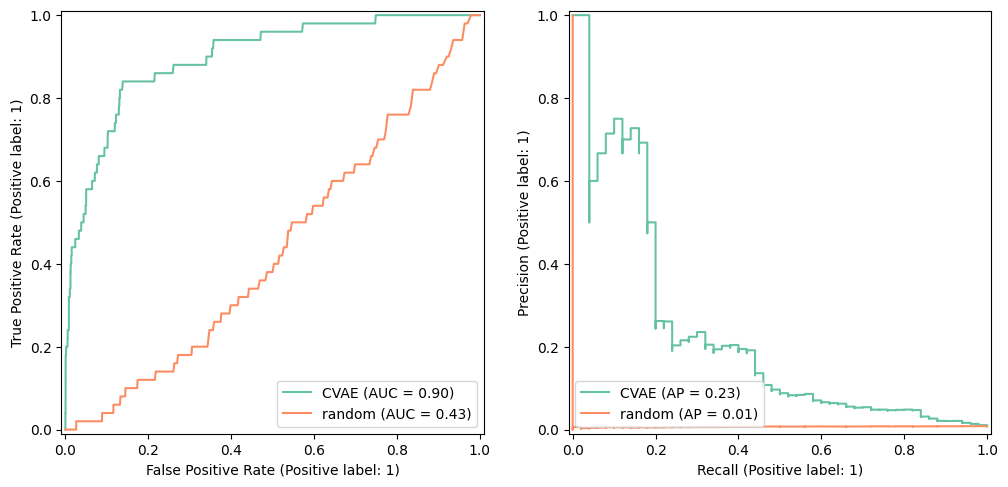

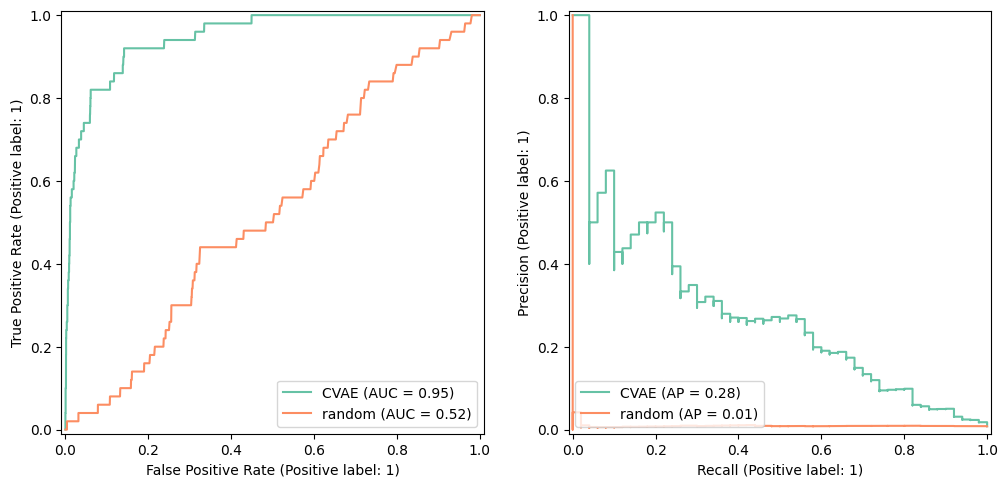

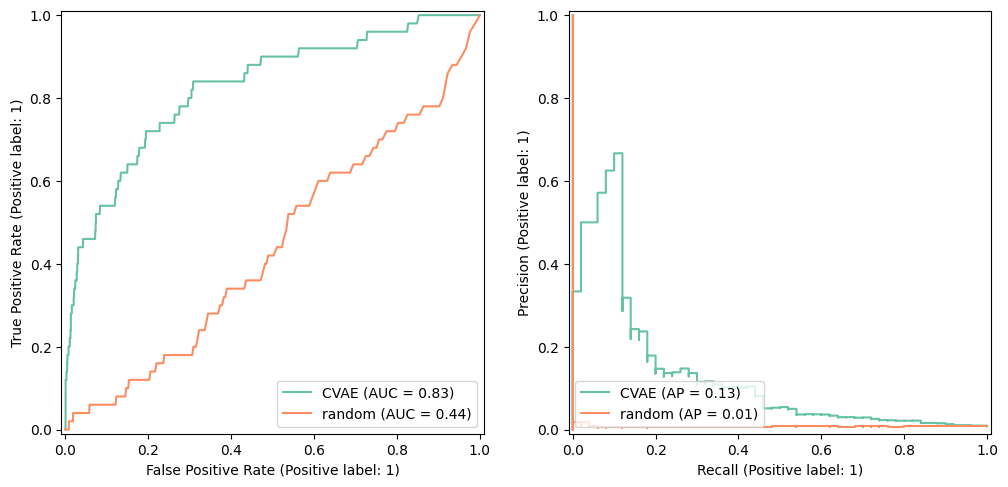

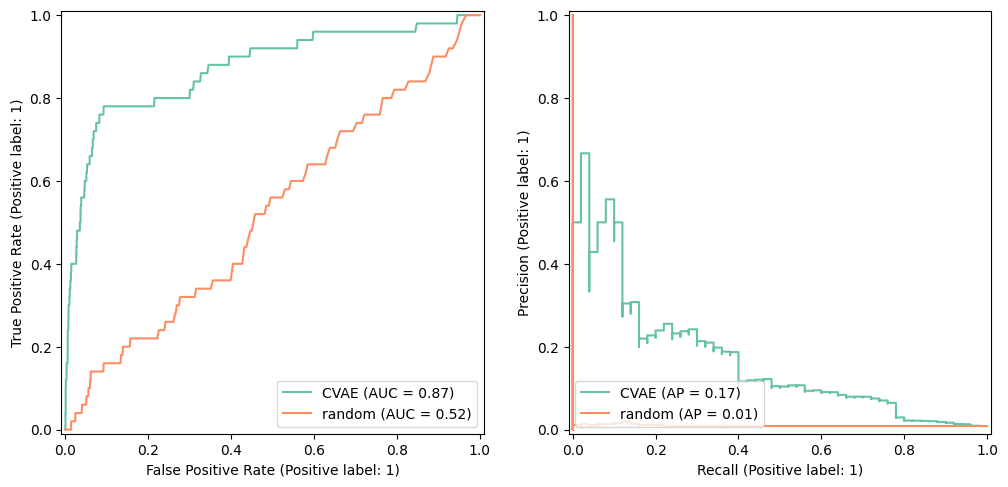

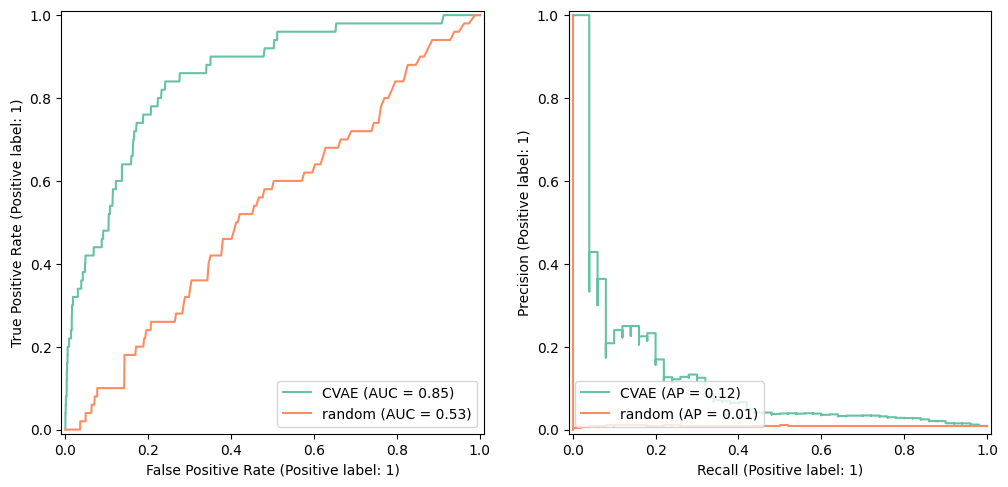

In [25]:
num_top = 50
pr_df1 = get_PRAUC(curr_treatment,
                    meta_df, X_full, 
                    bp_df, meta_bp_df, scaler, bp_union_genes, num_top)


prauc_res_file = os.path.join(res_data_path, f"{res_id}_{num_top}_BP_prauc.csv")
pr_df1.to_csv(prauc_res_file, index=False)

Fedratinib (SAR302503, TG101348)_K562 K562
Fedratinib (SAR302503, TG101348)_K562 K562


/tmp/ipykernel_1194819/3714465926.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.top_DE.iloc[range(0,num_top)] = 1


Tanespimycin (17-AAG)_K562 K562
Tanespimycin (17-AAG)_K562 K562


/tmp/ipykernel_1194819/3714465926.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.top_DE.iloc[range(0,num_top)] = 1


Trametinib (GSK1120212)_K562 K562
Trametinib (GSK1120212)_K562 K562


/tmp/ipykernel_1194819/3714465926.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.top_DE.iloc[range(0,num_top)] = 1


Triamcinolone Acetonide_K562 K562
Triamcinolone Acetonide_K562 K562


/tmp/ipykernel_1194819/3714465926.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.top_DE.iloc[range(0,num_top)] = 1


Trichostatin A (TSA)_K562 K562
Trichostatin A (TSA)_K562 K562


/tmp/ipykernel_1194819/3714465926.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.top_DE.iloc[range(0,num_top)] = 1


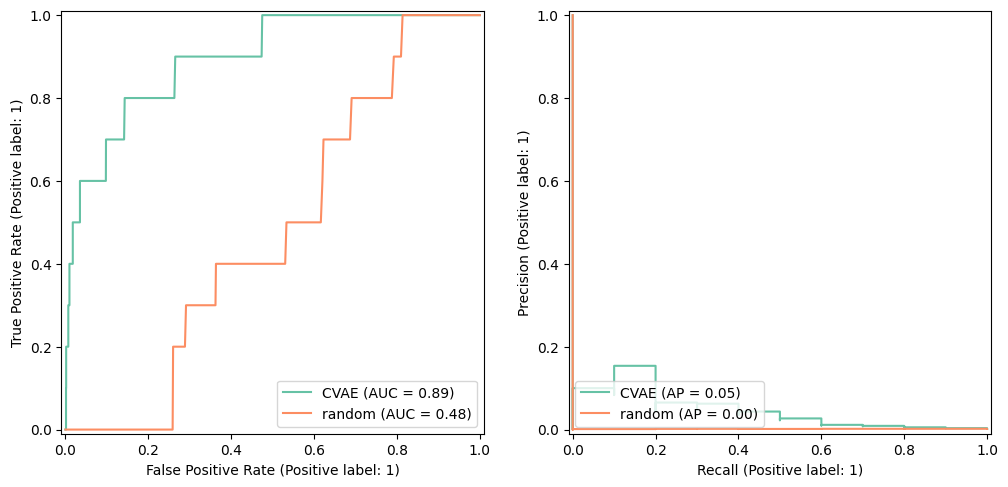

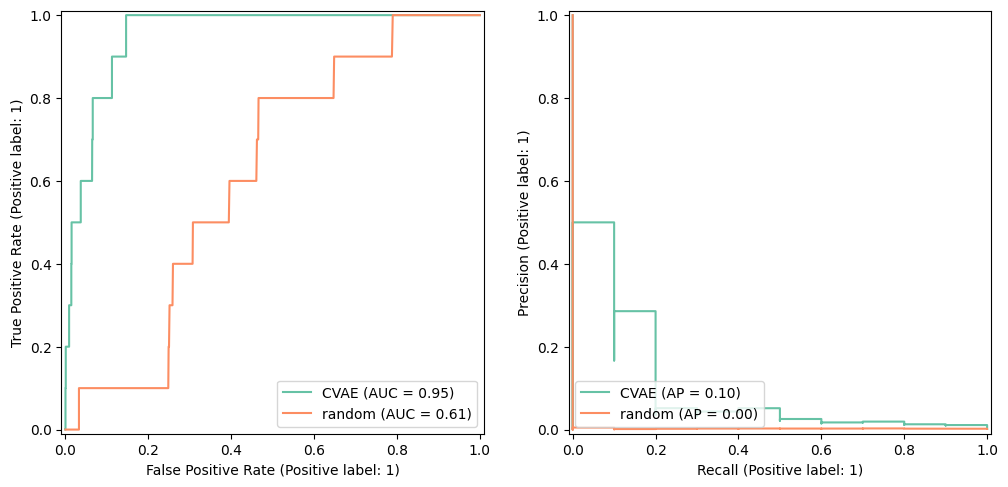

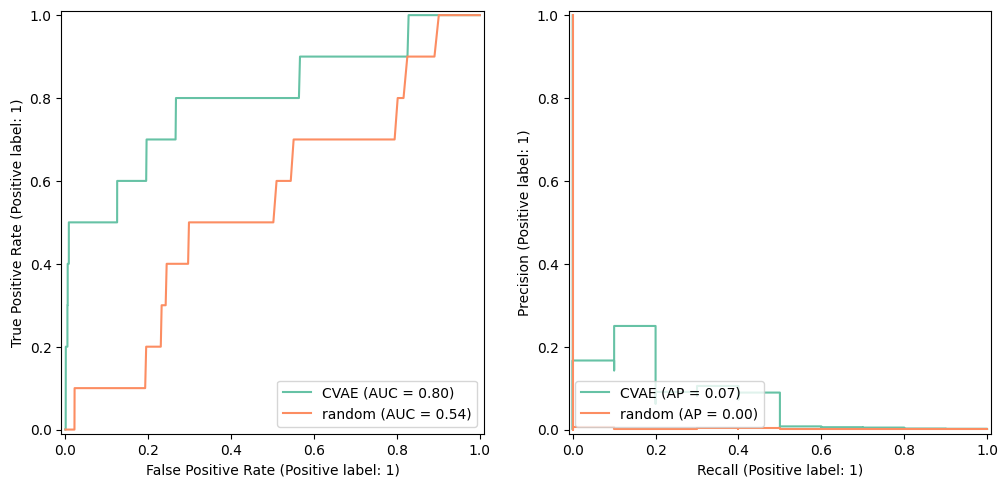

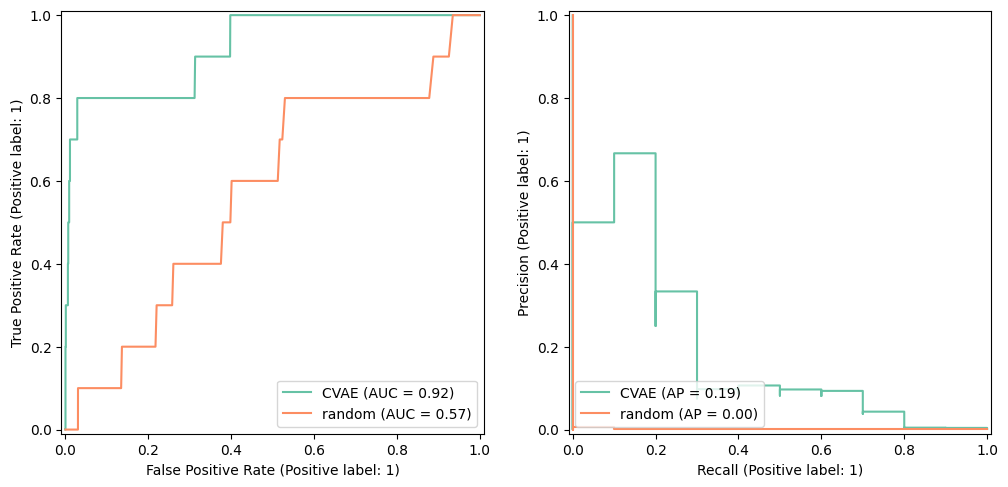

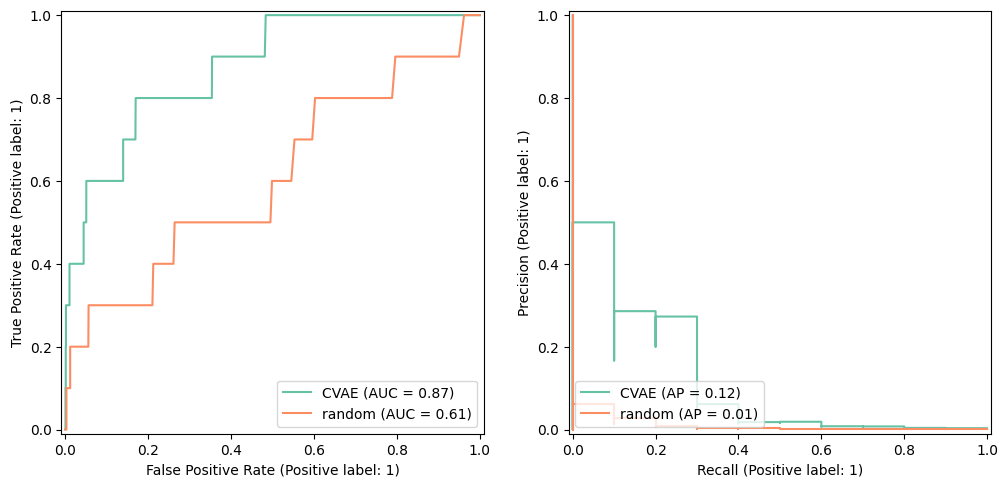

In [26]:
num_top = 10
pr_df1 = get_PRAUC(curr_treatment,
                    meta_df, X_full, 
                    bp_df, meta_bp_df, scaler, bp_union_genes, num_top)


prauc_res_file = os.path.join(res_data_path, f"{res_id}_{num_top}_BP_prauc.csv")
pr_df1.to_csv(prauc_res_file, index=False)

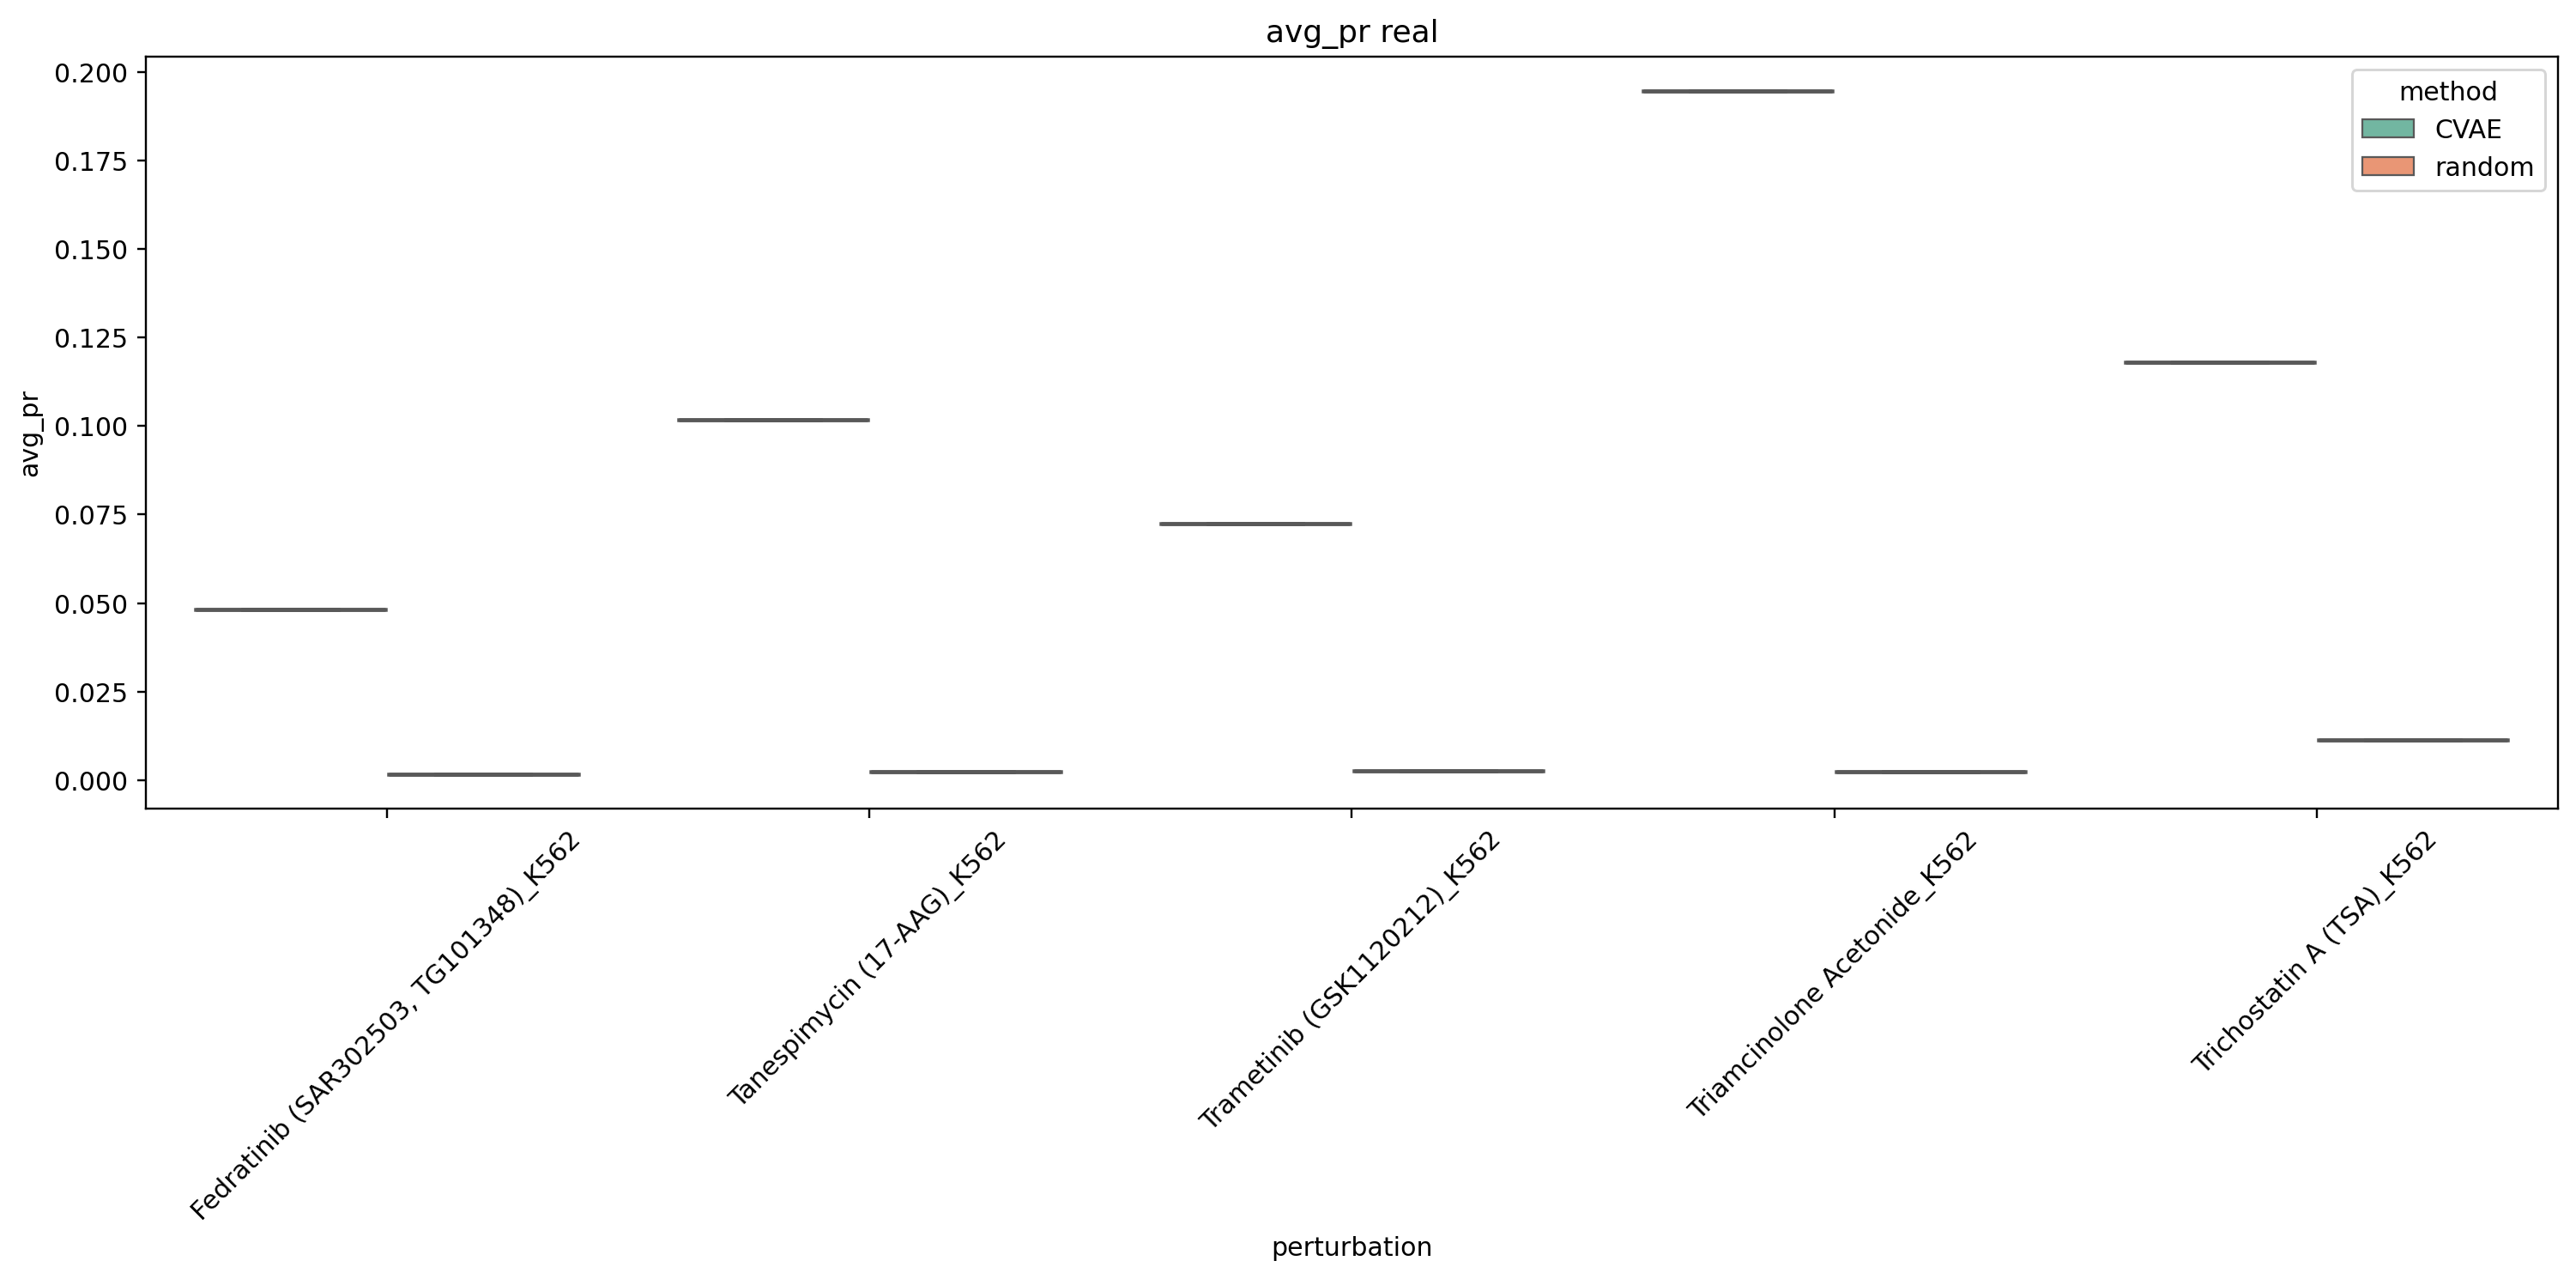

In [27]:

# plot
fig, axs = plt.subplots(1, 1, figsize=(14,7), dpi=216)

sns.boxplot(data=pr_df1, 
            x="perturbation", y="scores",
            hue="method", ax= axs)
axs.set_title("avg_pr real")
axs.set(ylabel="avg_pr")
axs.tick_params(axis='x', rotation=45)


fig.show()
fig.tight_layout()

